<h1>Day-1</h1>
<h2>An introduction to path integral molecular dynamics using i-PI</h2>
<h3> Venkat Kapil, Bingqing Cheng, Eszter Sarolta Pos </h3>


In this set of exercises we will learn about the basics of doing path integral molecular dynamics simulations using i-PI. We will begin by performing conventional molecular dynamics simulation of classical nuclei, and move towards highly quantum mechanical systems. In the process, the design principles, features and input/output format of i-PI will be introduced.

In [1]:
import argparse
import itertools
import sys
import csv
import numpy as np
import os
from ipi.utils.io import read_file_raw
from ipi.utils.units import unit_to_internal, unit_to_user
from ipi.utils.messages import verbosity
from matplotlib import pyplot as plt
from IPython.display import HTML
from checklist import fileChecker
from autocorr import autoCorr
from getRDF import RDF
fileChecker()


Everything is ready, you can start the tutorial.


<h2>Installing i-PI </h2>

This requires to have the i-PI git project cloned. 

 `$ git clone https://github.com/i-pi/i-pi` <br>

Since i-PI is python based, it doesn't require any compilation! To have access to the i-PI executables add the following to the ~/.bashrc file <br> 


 ```source MYIPIPATH/env.sh```

and source your bashrc file

`$ source ~/.bashrc`

Note that here `MYIPIPATH` implies the absolute path of the `i-pi` root directory.

<h2>Compiling LAMMPS</h2>

This requires to have the LAMMPS git project cloned. For this, we use the following procedure
https://lammps.sandia.gov/doc/Install_git.html

 `$ git clone -b stable https://github.com/lammps/lammps.git mylammps` <br>
 `$ cd mylammps/` <br>
 `$ git checkout stable` <br>
 `$ git pull` <br>
 `$ cd src/` <br>
 `$ make yes-user-misc` <br>
 `$ make yes-class2` <br>
 `$ make yes-molecule` <br>
 `$ make yes-kspace` <br>
 `$ make serial`


Update  ```$PATH``` with the MYLAMMPSPATH by adding the following to the ~/.bashrc file:
 ```export PATH="MYLAMMPSPATH/src:$PATH"```

`$ source ~/.bashrc`

Note that here `MYLAMMPSPATH` implies the absolute path of the `mylammps` root directory.

<h2>Compiling / Installing CP2K </h2>

A quick way to get access to precompiled CP2K binaries is by using conda

`$ conda install -c conda-forge cp2k` <br>


The alternative requires to have the CP2K git project cloned. For this, we use the following procedure
https://github.com/cp2k/cp2k/blob/master/INSTALL.md that required building the required libraries using toolchain

 `$ git clone https://github.com/cp2k/cp2k` <br>
 `$ cd cp2k/` <br>
 `$ cd tools/toolchain/` <br>
 `$ bash install_cp2k_toolchain.sh --with-libxsmm=install --with-openblas=system --with-fftw=system --with-reflapack=no  --enable-cuda` <br>

On successful installation, toolchain will give further instructions on how to select your `ARCHITECTURE` file. To compile the serial version 

`$ make -j N ARCH=ARCHITECTURE VERSION=sopt`

where `ARCHITECTURE` would correspond to the ARCH file as specified upon successful installation of the toolchain, and `N` is used to parallelize the compilation. 

Update  ```$PATH``` with the by adding the following to the ~/.bashrc file:
 ```export PATH="MYCP2KPATH/exe/ARCHITECTURE/:$PATH"```

`$ source ~/.bashrc`

Note that here `MYCP2KPATH` implies the absolute path of the `cp2k` root directory, and `ARCHITECTURE` implies the ARCH file as specified upon successful installation of the toolchain. 

For the purpose of the tutorial we recommend a quick installation using conda.

<h2>Exercise 1</h2>

We will start by providing a basic introduction to molecular dynamics. Under the Born-Oppenheimer approximation, the dynamics of the electronic degrees of freedom is completely decoupled from that of the nuclei, and the electrons always occupy the ground state for each configuration of the nuclei. In a fully classical treatment of nuclei, the additional assumption is made that their dynamics can be described in terms of the Hamiltonian

$$H (\mathbf{p},\mathbf{q}) = \sum_{i} \dfrac{p_i^2}{2m_i} + V(\mathbf{q})$$

where $m_i$ , $p_i$ and $q_i$ are the mass, the momentum and the coordinates of the $i^{\mathrm{th}}$ nucleus, respectively.</p>

In order to simulate the time evolution of particles in a system with this Hamiltonian, we need to take a couple of steps. The equation of motion can be written as

$$\dfrac{dp_i}{dt} = -\dfrac{\partial H(\mathbf{p},\mathbf{q})}{\partial q_i} = -\dfrac{dV(\mathbf{q})}{dq_i}$$
$$\dfrac{dq_i}{dt} = \dfrac{\partial H(\mathbf{p},\mathbf{q})}{\partial p_i} = \dfrac{p_i}{m_i}$$

The time domain can then be discretized into small and finite time steps with length $\Delta t$ . The key processes of a molecular dynamics run are illustrated in the flowchart below. At the initialization stage, the program is informed about some basic information about the system, such as the number of atoms, their types, system size, etc. After that, the program goes through the loop “Forces → Motion → Analysis” once per discrete simulation time step. The force acting on each atom

$$f_i = -\dfrac{\partial V(\mathbf{q})}{\partial q_i}$$

is evaluated first, and are then used to advance the momenta and the coordinates of the nucleus.

A simple integrator for the equations of motion (which is not generally used by any program) that evolves the position and momenta in time is given by 

 $$p_i (t + \Delta t) \leftarrow p_i(t) + f_i \Delta t $$
 
 $$q_i (t + \Delta t) \leftarrow q_i(t) + \dfrac{p_i}{m_i} \Delta t $$

In practice most programs use the Verlet integrator or higher order integrators which are much more accurate. At the analysis step, the properties of interest for the system can be computed, stored, or analyzed on the fly.

From the flowchart above, one can observe that each block of the program can be easily modularized. 
One can, for example, carry out the force evaluation using one program, and only communicate the results to another program which performs the motion and the analysis parts.
This is precisely the philosophy behind i-PI, which acts as a server that takes care of the evolution of nuclei and the evaluation of properties of the system, having as clients other programs that compute forces and potential energies. A graphical representation of how i-PI works is given in the scheme below.

In this exercise, we will perform a simple Molecular Dynamics (MD) calculation. Instead of doing the simulation directly using an out-of-the-box MD software such as LAMMPS [1], we are going to complete the task in a slightly more complex way. We are going to use i-PI in conjunction with LAMMPS to demonstrate a client/server model for (path integral) molecular dynamics as well as the subtle advantages that it brings. The simulation will be performed on one gas phase water molecule using NVT ensemble at 300K. We will also record the kinetic and potential energy of the system.

1. <p>Read the LAMMPS input file ex-1/in.water.
   The force field specifications 
  
   `pair_style lj/cut/tip4p/long 1 2 1 1 0.278072379 17.007` <br>
   `bond_style class2` <br>
   `angle_style harmonic` <br>
   `kspace_style pppm/tip4p 0.0001`
   
   mean that a q-TIP4P force field is being used. [2]
   In the part of the input file that specifies how to integrate the equations of motion, a line
   
    `fix 1 all ipi 300K-G.0 32345 unix`
    
   is used, which basically means LAMMPS will only be in charge of the force evaluation and send that information to i-PI. The latter will take care of the motion and the analysis parts. All the information will be transmitted through a UNIX-domain socket with the name `300K-G.0`, which is a mechanism for local, inter-process communication. 
    

2. Now open the i-PI input file input.xml in the same folder.
For a moment let us ignore all the other entries but only focus on the following
    
    ```<ffsocket name="tip4p" pbc="true" mode="unix">``` <br>
    ```<address> 300K-G.0 </address>``` <br>
    ```  </ffsocket>```

    This indicates that i-PI will receive any information sent by LAMMPS through the UNIX-domain socket with the tag `300K-G.0`, and send the coordinates of the nuclei in the system to LAMMPS for force evaluations using the same socket.


3. Let's run an i-PI+LAMMPS Molecular Dynamics simulation!
Open a terminal at the current directory and launch i-PI by typing

   `$ i-pi input.xml ` <br>
   
   At this point i-PI should start and parse the input file. At the bottom of the output on the screen it should say 
   
    `Created unix socket with address 300K-G.0` <br>
    `@ForceField: Starting the polling thread main loop.`

   This means i-PI has started properly, has created the UNIX socket, and is waiting for communication from the client(s) that do force evaluations.


4. Now it is a good time to start LAMMPS. Open up a second terminal either manually or by typing Ctrl+Shift+t and start LAMMPS by entering the command

   `$ lmp_serial < in.water ` <br>

   Then LAMMPS should start and dump out some outputs.


5. Now switch to the terminal where i-PI is running, notice that i-PI has built the connection with LAMMPS with the message

    `@SOCKET:   Client asked for connection from . Now hand-shaking.` <br>
    `@SOCKET:   Handshaking was successful. Added to the client list.`

   and started the Molecular Dynamics simulation. It should also dump out information on the time cost of each MD step. 
  

6. What we are going to do now is to kill LAMMPS. 
Simply switch to the terminal where LAMMPS is running and press Ctrl+c.
Now look at whether i-PI is still running. 
Notice that although the evolution of MD is paused, i-PI itself
does not die off but just waits for a new client to take over. 
Now start LAMMPS again by typing

   `$ lmp_serial < in.water` <br>
   
   What happens to i-PI now?


7. What if one stops i-PI? Kill i-PI by typing `Ctrl+c` where it is running, or create a file named `EXIT` in the folder where i-PI is running (you can use the bash command `touch EXIT` ). Watch how i-PI responds, and how LAMMPS reacts. Think about what are the advantages of a clean exit when a MD program stops unexpectedly.


8. Take a look at all the output files dumped by i-PI. You should have `gas-nvt-300k.out` that describe the system properties, gas-nvt-300k.xc.xyz that records the atomic trajectories, and RESTART that contains all the information to restart the simulation.





<h2>Exercise 2 - Keywords, outputs, and units of i-PI</h2>
In this exercise we are going to familiarize ourselves with the important notations of i-PI input files. Let's take a look at the input files in the folder <code>ex-2</code>. 
Here, the simulated system of choice is one gas phase water molecule using NVT ensemble at 300 K. We are going to use CP2K for force evaluations.


1. Let's take a close look at the units first - which are the source of many errors during simulation and analysis. All the units used internally by i-PI are atomic units, as given below.

    Unit        | Name          | SI value
    ------------|---------------|-----------------------
    Length      | bohr radius   | 5.2917721e-11 m
    Time        | n.a.          | 2.4188843e-17 s
    Mass        | electron mass | 9.1093819e-31 kg
    Temperature | hartree       | 315774.66 K
    Energy      | hartree       | 4.3597438e-18 J
    Pressure    | n.a.          | 2.9421912e13 Pa

   By default, both input and output data are given in atomic units, but in most cases the default units can be overridden if one wishes so. For example, in `ex-2/input.xml` we used

    ```<properties stride="1" filename="out"> [ step, time{picosecond}, conserved, temperature{kelvin},potential ] </properties>``` <br>
    ```<trajectory filename="xc" stride="1"> x_centroid{angstrom} </trajectory>```
    
    so that the time, temperature, and the trajectory will written out in the units of picosecond, Kelvin, and Angstrom in the output files, respectively. Similarly, the units of the initialization files can be specified such as 

    ```<file mode="xyz" units="angstrom"> h2o.xyz </file>``` <br>
    ```<velocities mode="thermal" units="kelvin"> 300 </velocities>```
    
    When using i-PI, you can play around with the units to facilitate the initialization process as well as subsequent analyses.
Please note that i-PI can read the unit cell from the comment line in the `.xyz` file. The cell and positions in the CP2K input file is just for the purpose of initializating the CP2K program and at the first simulation step both would be overridden.


2. Now we will observe the format and structure of <code>input.xml</code>. 
The `xml` file consists of a set of hierarchically nested tags. There are three parts to an xml tag. Each tag is identified by a tag name, which specifies the class or variable that is being initialized. Between the opening and closing tags there is some data, which is used to specify the contents of a class object, or the value of a variable. Finally, tags can have attributes, which are used to specify how the tag should be interpreted. 
A `xml` tag has the following syntax: 

    ```<tag_name attrib_name=attrib_data>tag_data</tag_name>```
    
   For example, in the tag
   
    ```<thermostat mode="langevin">``` <br>
    ```<tau units="femtosecond">100</tau>``` <br>
    ```</thermostat>```

   the tag name thermostat indicates which part of the simulation options is being defined, `mode="langevin"` specifies the type of thermostat in use, and 
`<tau units="femtosecond">100</tau>` is used to set the parameters used for this particular thermostat. 
Please browse around this `input.xml` to see if you can make sense of most of the attributes.


3. It is worth spending a bit more time to explain about the type of socket used here. For the communication between i-PI and client codes, both Internet and Unix domain sockets can be used: while the former make it possible to run i-PI and the clients on different computers, the latter allow for fast communication on a single node. Here we demostate how to use the Internet (TCP/IP) sockets. 
In i-PI inout file we have
    
    ```<ffsocket mode="inet" name="cp2k">``` <br>
    ```<latency> 1.00e-02</latency>``` <br>
   ``` <slots> 4 </slots>``` <br>
    ```<port> 20614 </port>``` <br>
    ```<timeout>  6.00000000e+02 </timeout>``` <br>
    ```<address> localhost </address>``` <br>
    ```</ffsocket>```

   and in CP2K input file `cp2k.in` we have the following
    
    `&MOTION` <br>
   ` &DRIVER` <br>
   ` HOST localhost` <br>
    `PORT 20614` <br>
    `&END DRIVER` <br>
    `&END MOTION` <br>

   The above means that an Internet domain socket with port number 20614 is used for the communication. 
The port number is an integer between 1 and 32767 used to distinguish between all the different sockets open on a particular host.
As many of the lower numbers are reserved for use in important system processes or Internet communication, it is generally advisable to only use numbers in the range 1025-32767 for simulations.


4.  Now let's see whether the Internet domain socket can indeed connect. 
    Type the following to start i-PI and CP2K:
     
    `$ i-pi input.xml &> log.ipi &` <br>
    `$ cp2k.ssmp -o h2o.out cp2k.in &`

    Does it work? If you have access to two computers that can communicate with each other on the same network, you can try to run in a distributed-computing mode, with i-PI running on one computer and CP2K on the other.
This advanced mode of operation, however, can be complex in the presence of firewalls or multiple network interfaces (see the i-PI documentation for some examples).


<h2><strong><span style="font-size:24px;">Exercise 3</span></strong></h2>
<h3><strong>Benchmark of quantum effects in a water molecule</strong></h3>

<p>In this exercise we will perform a series of PIMD calculations to observe and benchmark nuclear quantum effects in a molecular system. 
    Our system of choice will be a single molecule of water in vacuum so that simulations don't take too much time and memory. 
    We will be sampling the NVT ensemble using a q-TIP4P/f forcefield implemented within LAMMPS. 
    We will look at the change in the kinetic and potential energy and the Oxygen–Hydrogen pair distribution function as we simulate in the quantum regime.
    

1. Look at the i-PI input file in `n.01/input.xml`. It is an i-PI input for a molecular dynamics simulations. Observe the properties and trajectory files that are specified in the `<output></output>` section. From the previous exercise, it should be clear that the quantum kinetic and potential energy will be printed out every 4 MD steps as columns 4 and 5 in the `$prefix.out` file. To compute the Oxygen–Hydrogen pair distribution function we shall also print out the positions of the atoms every 40 MD steps int the `$prefix.pos_0` file.

    
2.   Observe the `<initialize></initialize>` section. We will be initialzing from a checkpoint file init.chk which is basically a RESTART file of a long equilibration run. From the previous exercise, it should be clear that the option nbeads should be 1 for a classical simulation.
    
       `<initialize nbeads="1">` <br>
    `<file mode="chk"> init.chk </file>` <br>
    `</initialize>`

    
3. Observe the `<motion></motion>` section. 
The tags within the section should be verbose enough to help you interpret their meaning. We will be using a PILE-L thermostat which for the case of a classical simulation reduces to a white noise Langevin thermostat. To be consistent with the rest of the PIMD runs, we will use an over-conservative time step of 0.25 fs.

    
4.  To run the simulation launch i-PI and lammps in background. 
It is advisable to keep separate logs as useful information can be extracted from them.

    `$ i-pi input.xml &> log.ipi &` <br>
    `$ lmp_serial < in.lmp &> log.lmp &`

    To compute the average values of the observable use a function `autocorr()` which takes a time series as an input and evaluates its auto-correlation function. Among others, it takes the variable `mlag` as an input variable which is the cutoff at the auto-correlation function is truncated. In addition to that it also computes the `average` and the `associated error`. You can find the function itself coded in python in the home directory of `day-1`.

In [3]:
infile = 'ex-3/n.01/simulation.out'
if not (os.path.isfile(infile)): print('You are missing the file: '+infile+
                                      '\nHave you run i-pi in the correct directory (n.01)?')
mean,error = autoCorr('ex-3/n.01/simulation.out', nbead=1, columns=[5], mlag=10, nequi=99, dt=1.0, verbosity = 2)

================================== 1 bead =============================================
 mean = 4.1922e-02  |  variance: = 1.0266e-03  |  st.dev. = 3.2041e-02
<tau> = 3.8687e+00  |    <tau^2> = 2.3697e+00  |  error = 1.1039e-03
        time               acf             Dacf            block              Dblock   
---------------------------------------------------------------------------------------
     0.00000000        1.00000000        0.00000000        0.00000000        0.00000000
     1.00000000        0.66094704        0.00914271        1.00000000        0.01348271
     2.00000000        0.19145551        0.02180275        1.66094704        0.01782272
     3.00000000        0.25181131        0.02017523        2.00889972        0.01372270
     4.00000000        0.51930599        0.01296212        2.30878172        0.00832643
     5.00000000        0.36349917        0.01716352        2.69643331        0.00529691
     6.00000000       -0.02229744        0.02756669        3.0760341

5. To compute the oxygen–hydrogen pair correlation function we suggest you to use `getRDF.py` and follow the syntax as shown.

    `$ python ../../getRDF.py $prefix "xyz" O H 200 0. 2. 0.1`

    Where the flag activates the computation of a pair correlation for atom types specified in the call between a minimum and a maximum distance given, creating a histogram with a specified resolution.
    Use the cell below to plot the resulting radial distribution function.



 number of beads = 1,  Processing frame 700 

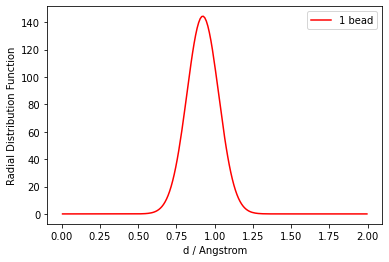

In [4]:
os.chdir('ex-3/n.01/')
RDF('simulation', "xyz", 'O', 'H', 200, 0., 2., 0.1)
os.chdir('../../')

infile = 'ex-3/n.01/simulation.OH.rdf.dat'
if not (os.path.isfile(infile)): print('You are missing the file: '+infile+
                                      '\nHave you calculated the OH pair correlation function?')
rdf_01 = np.genfromtxt(infile)

fig, ax = plt.subplots()
ax.plot(rdf_01[:,0],rdf_01[:,1],'r-',label = "1 bead")
ax.set_xlabel('d / Angstrom')
ax.set_ylabel('Radial Distribution Function')
plt.legend()
plt.show()

6. Now go one folder up, and create new folder, copying all the input files for `n.01`. You can obtain an equilibrated of the extended system of 32 replicas of our system from `n.32/init.chk`.

    `$ mkdir pi-test` <br>
    `$ cp n.01/input.xml n.01/*.lmp pi-test` <br>
    `$ cp n.32/init.chk pi-test` <br>
    `$ cd pi-test`


7. Modify the input files so that you will run a PIMD calculation with 32 beads. Make the modifications as indicated by the comments in the `xml` snippet.

    change nbeads to 32 <br>
    `<initialize nbeads="1">` <br>
    `<file mode="chk" units="angstrom"> init.chk </file>` <br>
    `</initialize>` <br>
    `<ffsocket mode="unix" pbc="false" name="driver">`
   
   change the addess to driver.32 <br>
    `<address>driver.01</address>` <br>
    `<port>31400</port>` <br>
    `<latency>0.001</latency> <timeout>400</timeout>` <br>
    `</ffsocket>`
    
    
8.  Do not forget to change the address in the lammps input file. The comments in the following snippet should guide you.
     
    `neighbor 2.0 bin` <br>
    `timestep 0.00025` <br>
    replace `driver.01` with `driver.32` <br>
    `fix 1 all ipi driver.01 32346 unix` <br>
    `run 100000000`


9. The folders `n.*` have already been prepared for you to run simulations with increasing numbers of beads. You should start one PIMD calculation in each of those folders.
    Compute the pair correlation function and the energy for all the simulations using the scripts `autocorr.py` and `getRDF.py`.

10. In the following cell we will generate the average value and the error associated with the respective observables tabulated against the number of beads in the `$prefix.out` files. 
    What are the units? 
    Hints: Have a look at the header of the output files of i-PI. Unless otherwise specified, all outputs are in atomic units.
   
    You should observe that the kinetic and potential energy individually converge to their quantum limit for `nbeads ∼ 32`.

nbead|=========potential=========|==========kinetic=========
-----|-----mean---------error----|-----mean---------error---
  1  | 3.9357e-02 +/- 1.0121e-03 | 1.1633e-01 +/- 0.0000e+00
  2  | 8.0121e-02 +/- 1.6187e-03 | 1.5056e-01 +/- 8.8686e-04
  4  | 1.3672e-01 +/- 2.2528e-03 | 2.0827e-01 +/- 1.4821e-03
  8  | 2.0236e-01 +/- 2.6167e-03 | 2.7531e-01 +/- 1.8560e-03
 16  | 2.5793e-01 +/- 3.6230e-03 | 3.3238e-01 +/- 2.1870e-03
 32  | 2.9067e-01 +/- 7.9299e-03 | 3.5230e-01 +/- 3.5598e-03
 64  | 2.9427e-01 +/- 5.9018e-03 | 3.6749e-01 +/- 3.9088e-03


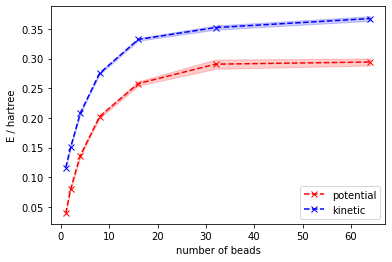

In [5]:
beads = np.array(['01','02','04','08','16','32','64'])
potMean = np.zeros((len(beads)))
potError = np.zeros((len(beads)))
kinMean = np.zeros((len(beads)))
kinError = np.zeros((len(beads)))
beadnum = np.zeros((len(beads)))
count = 0

print('nbead|=========potential=========|==========kinetic=========')
print('-----|-----mean---------error----|-----mean---------error---')

for i in beads:
    infile = 'ex-3/n.'+str(i)+'/simulation.out'
    if not (os.path.isfile(infile)): print('You are missing the file: '+infile+
                                      '\nHave you run i-pi in all directories?')
    potMean[count],potError[count] = autoCorr(infile, nbead=int(i), columns=[5], mlag=10,
                                              nequi=99, dt=1.0, verbosity = 0)
    kinMean[count],kinError[count] = autoCorr(infile, nbead=int(i), columns=[3,4], mlag=10,
                                              nequi=99, dt=1.0, verbosity = 0)
    beadnum[count] = int(i)
    print('%3d  | %8.4e +/- %8.4e | %8.4e +/- %8.4e'%(int(i),potMean[count],potError[count],kinMean[count],kinError[count]))
    count +=1

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads
plt.fill_between(beadnum, potMean-potError, potMean+potError, color='red', alpha=0.2 )
plt.plot(beadnum,potMean,'rx--', label='potential')
plt.fill_between(beadnum, kinMean-kinError, kinMean+kinError, color='blue', alpha=0.2 )
plt.plot(beadnum,kinMean,'bx--', label='kinetic')
plt.xlabel('number of beads')
plt.ylabel('E / hartree')
plt.legend()
plt.show()

11. Executing `extract-gOH.bash` and will create a file called <code>${prefix}.OH.rdf.dat</code> inside each of the sub directories <code>n.*</code>.
    
    `$ bash extract-gOH.bash` <br>

    We are going to plot each of the pair distribution functions and see how they converge with number of beads. You should observe the broadening of the probability distributions as you approach the quantum limit. We are showing a smoothed version of the radial distribution functions that is created by the applying a Bartlett window function to the original signal.

 number of beads = 64,  Processing frame 0 0 

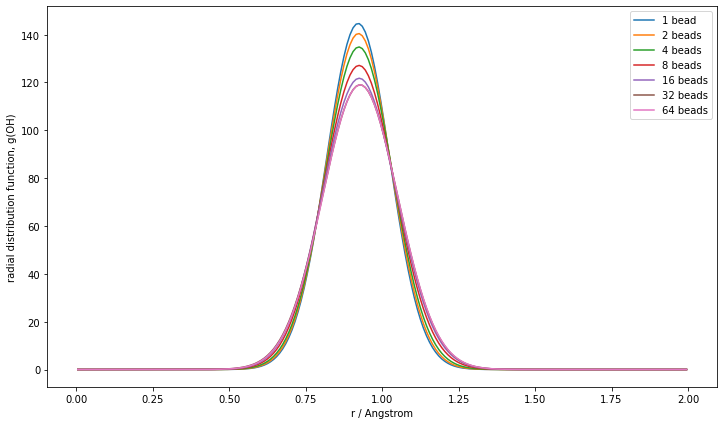

In [6]:
beads = np.array(['01','02','04','08','16','32','64'])
nbins = 200
rdf = np.zeros((len(beads),nbins))
dist = np.zeros((len(beads),nbins))
count = 0
fig,ax = plt.subplots(figsize=(12,7))

for i in beads:
    os.chdir('ex-3/n.%s/'%i)
    RDF('simulation', "xyz", 'O', 'H', 200, 0., 2., 0.1)
    os.chdir('../../')
    
    infile = 'ex-3/n.'+str(i)+'/simulation.OH.rdf.dat'
    if not (os.path.isfile(infile)): print('You are missing the file: '+infile+
                                      '\nHave you run the command: ./extract-gOH.bash ?')
    rdf[count,:] = np.genfromtxt(infile,usecols = 1) 
    dist[count,:] = np.genfromtxt(infile,usecols = 0)
    plt.plot(dist[count,:],rdf[count,:],label=str(int(i))+' beads' if int(i)>1 else str(int(i))+' bead')
    count +=1

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(OH)')
#ax.set_xlim([0.7,1.3])
plt.legend(loc = 1)
plt.show()

<h2><strong><span style="font-size:24px;">Exercise 4</span></strong></h2>
<h3><strong>PIMD in the strong quantum regime: gas phase Methanium</strong></h3>

<p> Having benchmarked nuclear quantum effects in a water molecule at room temperature we will study a $CH_5^+$ at 100 K where quantum effects such as tunneling and zero point fluctuations become strong. 
For a water molecule at 300 K, ~32 beads were sufficient to accommodate NQEs, however in this case we will use 128 beads since at low temperature quantum effects are stronger. 

Hints: (Remember: the error in primitive PIMD converges as $(T/P)^2$. 
In other words, this simulation is ~128 times more computationally demanding than classical MD. 
We shall be sampling a NVT ensemble and will monitor the proton  delocalization by computing the Hydrogen–Hydrogen pair distribution function. 
For the purpose of comparison we will also run a cheap MD.

1. Move to the directory `ex-4/` and carefully observe the i-PI input files `n.001/input.xml` and `n.128/input.xml`. You will be initializing from an already thermalized restart file called `init.chk`. We shall also be printing out the trajectory every 1 fs so that we have enough frames to compute the Hydrogen–Hydrogen pair distribution function. Run the classical and quantum simulations in their respective directories. 
    
    `$ i-pi input.xml &> log.ipi &` <br>
    `$ cp2k.ssmp in.cp2k &> log.cp2k &` 

2. To compute the Hydrogen–Hydrogen pair correlation function we suggest you to use `getRDF.py` and follow the syntax as shown. </li>

   `$ python ../../getRDF.py simulation "pdb" H H 200 0. 3. 0.1`

3. We are going to visualize the difference in the pair distributions functions with and without PIMD. To get smoothened radial distribution functions we are using a Bartlett window.

In [ ]:
beads = np.array(['001','128'])
nbins = 200
rdf = np.zeros((len(beads),nbins))
dist = np.zeros((len(beads),nbins))
count = 0
fig,ax = plt.subplots()

for i in beads:
    os.chdir('ex-4/n.'+str(i))
    RDF('simulation', "pdb", 'H', 'H', 200, 0., 3., 0.1)
    os.chdir('../../')
    infile = 'ex-4/n.'+str(i)+'/simulation.HH.rdf.dat'
    if not (os.path.isfile(infile)): print('You are missing the file: '+infile+
                                      '\nHave you calculated the pair correlation function?')
    rdf[count,:] = np.genfromtxt(infile,usecols = 1) 
    dist[count,:] = np.genfromtxt(infile,usecols = 0)
    plt.plot(dist[count,:],rdf[count,:],label=str(int(i))+' beads' if int(i)>1 else str(int(i))+' bead')
    count +=1

# Plotting the kinetic and potential energies and the corresponding errors as a function of the number of beads 
plt.xlabel('r / Angstrom')
plt.ylabel('radial distribution function, g(HH)')
ax.set_xlim([0.,3.])
plt.legend(loc = 1)
plt.show()

<h2><strong><span style="font-size:24px;">References </span></strong></h2>

[1] Steve Plimpton. Fast Parallel Algorithms for Short-Range Molecular Dynamics.  J. Comp. Phys., 117:1–19, <strong>1995</strong>.
<br>[2] Scott Habershon, Thomas E Markland, and David E Manolopoulos. Competing quantum effects in the dynamics of a flexible water model. J. Chem. Phys., 131:24501, <strong>2009</strong>.
<br>[3] CP2K. http://www.cp2k.org.
<br>[4] Michele Ceriotti, Michele Parrinello, Thomas E Markland, and David E Manolopoulos. Efficient stochastic thermostatting of path integral molecular dynamics. J. Chem. Phys., 133:124104, <strong>2010</strong>.